# Loudspeaker simulation in free field - Nahuel Passano

Simulation based on Lampton arrays that allows to describe the behaivor of the loudspeaker in free-field.

#1. Libraries and auxiliar functions

## Libraries needed

In [67]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Auxiliar functions

In [68]:
def bessel(z):
    """
    Bessel function aproximation for air radiation impedance
    """
    bessel_sum = 0
    for k in range(25):
        bessel_i = ((-1)**k * (z/2)**(2*k+1)) / (np.math.factorial(k) * np.math.factorial(k+1))
        bessel_sum = bessel_sum + bessel_i
    return bessel_sum

def struve(z):
    """
    Srtuve function aproximation for air radiation impedance
    """
    struve_sum = 0
    for k in range(25):
        struve_i = (((-1)**k * (z/2)**(2*k+2))) / (np.math.factorial(int(k+1/2)) * np.math.factorial(int(k+3/2)))
        struve_sum = struve_sum + struve_i
    return struve_sum    

def dB(x):
    """
    deciBel calculus
    """
    deciBel = 20*np.log10(np.abs(x))
    return deciBel

#2. Thiele-Small parameters

Linear parameters of the loudspeaker needed to simulate:

In [69]:
Re = 6.3                                    # Electric resistance of the coil [ohm]
Le = 1.534 *10**(-3)                        # Inductance of the coil [mH] 
Bl = 5.089                                  # Electromechanical factor [N/A]
Mm = 12.35 *10**(-3)                        # Mechanical mass [g]
Cm = 0.671 *10**(-3)                        # Mechanical compliance [mm/N]
Rm = 0.745                                  # Mechanical resistance [N/(m/s)] = [kg/s]
diam = 13.4 *10**(-2)                       # Effective diameter of radiation [cm] 

Calculus of the rest Thiele-Small parameters

In [70]:
n=2000
f = np.logspace(np.log10(10),np.log10(4000),num=n) # Frequency array
w = 2*np.pi*f

Ac_c = 343                                  # Sound speed [m/s]
Ac_rho0 = 1.16                              # Air density [kg/m^3]
Ac_p0 = 101325                              # Atmospheric pressure [Pa]
Ac_p_ref = 20*10**(-6)                      # Reference pressure[Pa]
Ac_Zs = Ac_rho0*Ac_c                        # Characteristic air impedance

k = w/Ac_c                                  # Wave number
a = diam/2                                  # Effective radius of radiation [cm]
Sd = np.pi*a**2                             # Effective surface of radiation [cm^2]
ka = k*a
f_ka_1 = Ac_c / (2*np.pi * a)               # Pistonic behaivor boundary

fs = 1 / (2*np.pi*(Mm*Cm)**(1/2))           # Mechanic resonance frequency
Qm = 2*np.pi*fs*(Mm+0.00092)/Rm             # Mechanic selectivity factor
Qe = 2*np.pi*fs*(Mm+0.00092)/(Bl**2/Re)     # Electric selectivity factor
Qt = (Qm*Qe) / (Qm+Qe)                      # Total selectivity factor
Vas = (Cm * Sd**2 * Ac_rho0 * Ac_c**2)*1000 # Suspension acoustic volume
eta = (9.68*10**(-7) * fs**3 * Vas/Qe)      # Performance

# 3. Lampton arrays

Arrays of the electrical and mechanical elements

In [71]:
T_Re = np.array([[1 , Re ],                 # Electric resistance of the coil
                  [0 , 1  ]])

T_Le = np.array([[1 , 1j*w*Le ],            # Inductance of the coil
                  [0 , 1       ]])    

G_Bl = np.array([[0    , Bl ],              # Electromechanical factor 
                  [1/Bl , 0  ]]) 

T_Mm = np.array([[1 , 1j*w*Mm ],            # Mechanical mass
                  [0 , 1       ]]) 

T_Cm = np.array([[1 , 1/(1j*w*Cm) ],        # Mechanical compliance
                  [0 , 1           ]]) 

T_Rm = np.array([[1 , Rm ],                 # Mechanical resistance 
                  [0 , 1  ]])

    # Array of mechanic engine
T_motor = np.dot(np.dot(np.dot(np.dot(np.dot(T_Re,T_Le),G_Bl),T_Mm),T_Cm),T_Rm)

T_Sd = np.array([[Sd , 0    ],              # Mechanoacoustic surface factor
                  [0  , 1/Sd ]])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you m

Radiation impedance transferred to the mechanical world though effective surface.

In [72]:
ZM_rad_real = np.pi*(a**2)*Ac_Zs*(1-bessel(2*ka)/ka) 
ZM_rad_imag = np.pi*(a**2)*Ac_Zs*(1j*(struve(2*ka)/ka))
ZM_rad = ZM_rad_real + ZM_rad_imag

T_ZM = np.array([[1 , ZM_rad],            # Radiation impedance array
                  [0 , 1     ]])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


Specific acoustic impedance for spherical propagation

In [73]:
d=1                                         # Measurement distance [m]
Q=2                                         # Directivity factor

    # Specific acoustic impedance
ZA_rad = (1j * w * Ac_rho0 * Q)/(4*np.pi * d * np.exp(1j*k*d)) 
Z_delay = 1j*np.exp(-1j * k * d)            # Phase rotation due air propagation time

Final array that describes the loudspeaker

In [74]:
T_total = np.dot(np.dot(T_motor,T_ZM),T_Sd)

# 4. Impedance response

In [75]:
    # Variables initializer
Z_in_Imp = np.zeros(n,dtype = 'complex')
Z_io_Imp = np.zeros(n,dtype = 'complex')
I_in_Imp = np.zeros(n,dtype = 'complex')
out_Imp = np.zeros((2,n),dtype = 'complex')

V_in_Imp = 1                                 # Input voltage

    # Final array of the loudspeaker components
A_Imp = T_motor[0,0]
B_Imp = T_motor[0,1]
C_Imp = T_motor[1,0]
D_Imp = T_motor[1,1]


for i in range(n):
  det = np.abs(A_Imp[i]*D_Imp[i]-B_Imp[i]*C_Imp[i])
  T_inv = np.array([[  D_Imp[i]/det , -B_Imp[i]/det ],
                    [ -C_Imp[i]/det ,  A_Imp[i]/det ]])

  Z_in_Imp[i] = B_Imp[i] / D_Imp[i]        # Impedance with Z_L=0.
  Z_io_Imp[i] = A_Imp[i] / C_Imp[i]        # Impedance with Z_L=inf.
  I_in_Imp = V_in_Imp / Z_in_Imp[i]        # Input current.

      # Force and velocity in function of frequency 
  out_Imp[:,i] = np.dot(T_inv , np.array([V_in_Imp,I_in_Imp]))

# 5. Frequency response


In [76]:
    # Variables initializer
Z_L = np.zeros(n,dtype = 'complex')          
Z_in = np.zeros(n,dtype = 'complex')         
Z_out = np.zeros(n,dtype = 'complex')        
H = np.zeros(n,dtype = 'complex')
Z_rad = np.zeros(n,dtype = 'complex')
SPL = np.zeros(n,dtype = 'complex')

V_in = 2.83                                 # Input voltage

Z_L = ZA_rad                                # Load impedance (Z_L)

        # Final array of the loudspeaker components
A = T_total[0,0]
B = T_total[0,1]
C = T_total[1,0]
D = T_total[1,1]

for i in range(n):
  Z_in[i] = B[i]/D[i]                     # Impedance with Z_L=0.
  Z_out[i] = D[i]/C[i]                    # Impedance with Z_L=inf.
  H[i] = Z_L[i] / (A[i]*Z_L[i]+B[i])      # Transfer function between voltage and pressure.

    # Frequency response in pressure.
SPL =  V_in*( H / Z_delay ) / Ac_p_ref
Z_rad = ZM_rad / (np.pi * a**2 * Ac_Zs)     # Radiation impedance.

f_100_index = np.argmin(np.abs(f-100))      # f = 100 Hz index
f_500_index = np.argmin(np.abs(f-500))      # f = 1 kHz index

    # Average sensitivity
sens = np.mean(dB(SPL[f_100_index:f_500_index])) 

# 6. Graphs


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:136: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


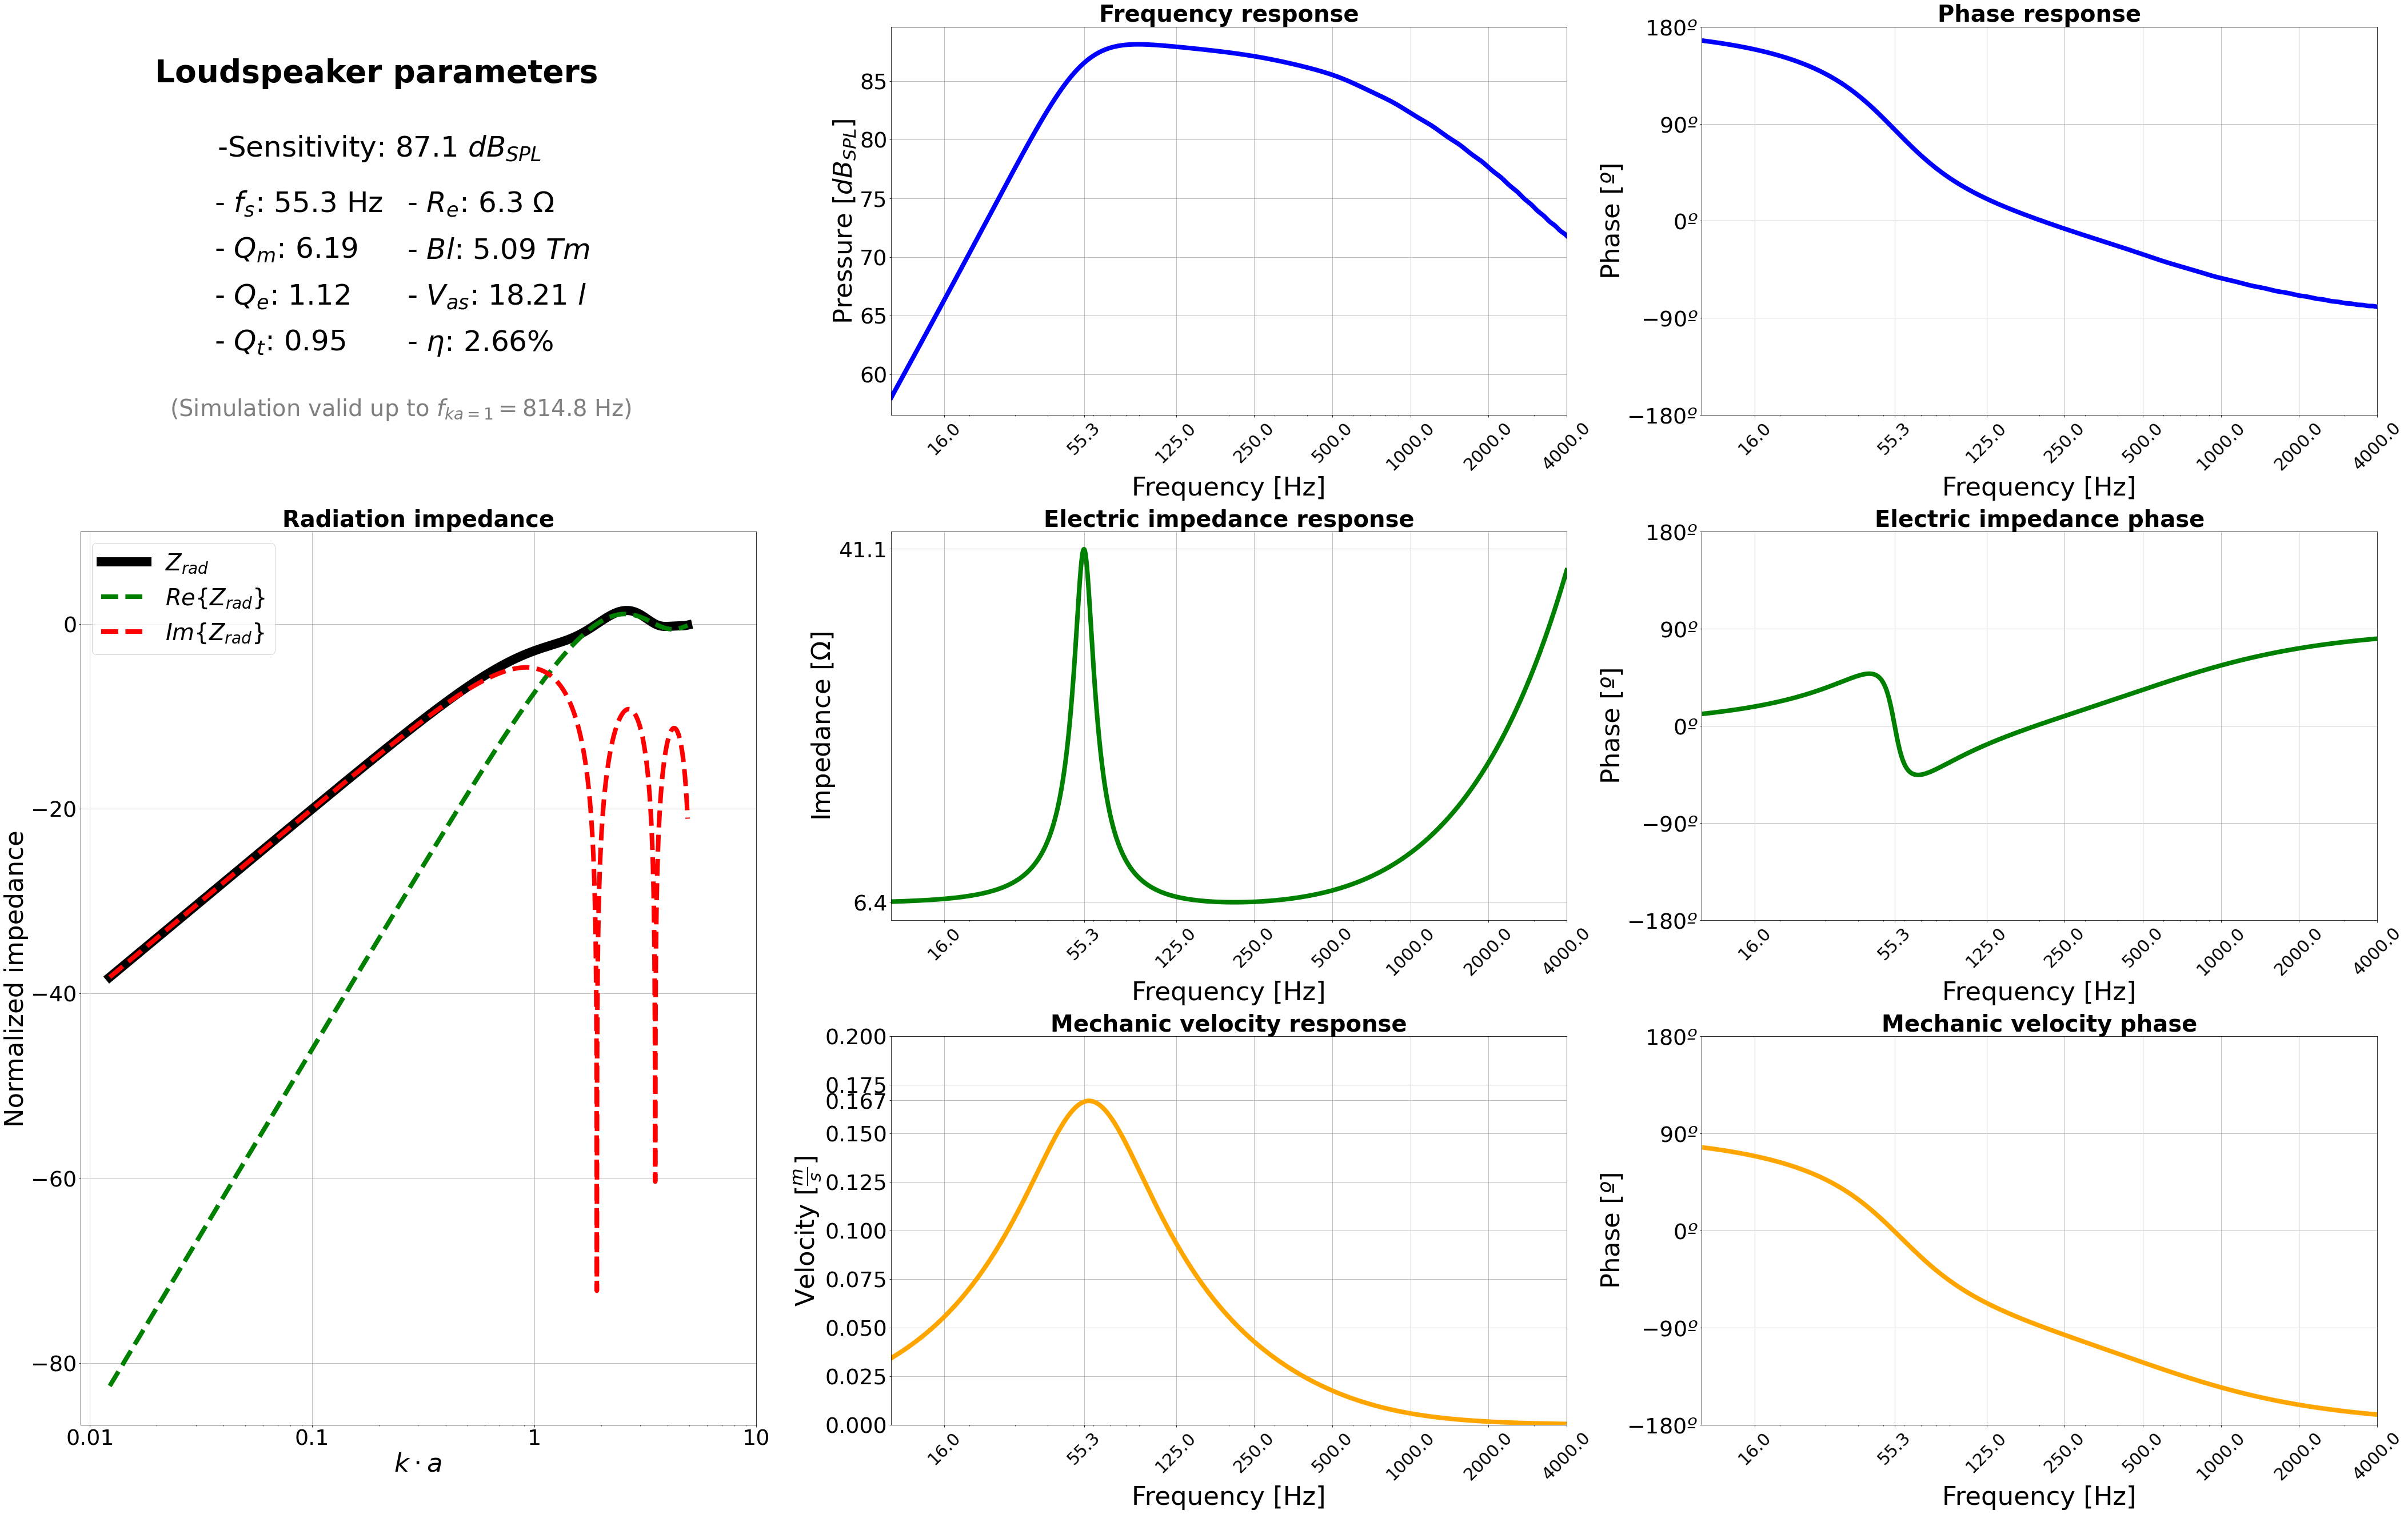

In [77]:
fig = plt.figure(figsize=(72, 45))
plt.subplots_adjust(hspace=0.3,wspace=0.2)

title = 'Loudspeaker parameters'
plt.figtext(0.15,0.85,s=title,fontsize=55,fontweight='bold')

sens_text = '-Sensitivity: ' + str(round(sens,1)) + ' $dB_{SPL}$'
plt.figtext(0.171,0.81,s=sens_text,fontsize=50)

fs_text = '- $f_s$: ' + str(round(fs,1)) + ' Hz'
plt.figtext(0.17,0.78,s=fs_text,fontsize=50)

Qm_text = '- $Q_m$: ' + str(round(Qm,2))
plt.figtext(0.17,0.755,s=Qm_text,fontsize=50)

Qe_text = '- $Q_e$: ' + str(round(Qe,2))
plt.figtext(0.17,0.73,s=Qe_text,fontsize=50)

Qt_text = '- $Q_t$: ' + str(round(Qt,2))
plt.figtext(0.17,0.705,s=Qt_text,fontsize=50)

Re_text = '- $R_e$: ' + str(round(Re,1)) + ' $\Omega$'
plt.figtext(0.235,0.78,s=Re_text,fontsize=50)

Bl_text = '- $Bl$: ' + str(round(Bl,2)) + ' $Tm$'
plt.figtext(0.235,0.755,s=Bl_text,fontsize=50)

Vas_text = '- $V_{as}$: ' + str(round(Vas,2)) + ' $l$'
plt.figtext(0.235,0.73,s=Vas_text,fontsize=50)

eta_text = '- $\eta$: ' + str(round(eta,2)) + '$\%$'
plt.figtext(0.235,0.705,s=eta_text,fontsize=50)

ka1_text = '(Simulation valid up to $f_{ka=1} = $' + str(round(f_ka_1,1)) + ' Hz)' 
plt.figtext(0.155,0.67,s=ka1_text,fontsize=40,color='grey')

    # Frequency (Magnitude)
    
plt.subplot2grid((3,3),(0,1))
plt.semilogx(f,dB(SPL), linewidth=8, color='blue')
plt.title(r'Frequency response', fontsize=40,fontweight="bold")
plt.ylabel(r'Pressure [$dB_{SPL}$]', fontsize=45)
plt.xlabel('Frequency [Hz]',fontsize=45)
x_ticks = np.sort(np.array([16,125,250,500,1000,2000,4000,round(fs,1)]))
plt.xticks(ticks = x_ticks,labels = x_ticks.tolist() ,fontsize=30, rotation=45)
plt.yticks(fontsize=38) 
plt.xlim(10,4000)
plt.grid()

    # Frequency (Phase)

plt.subplot2grid((3,3),(0,2))
plt.semilogx(f,np.angle(SPL)*57.29+90, linewidth=8, color='blue')
plt.title(r'Phase response', fontsize=40,fontweight="bold")
plt.ylabel(r'Phase [$º$]', fontsize=45)
plt.xlabel('Frequency [Hz]',fontsize=45)
x_ticks = np.sort(np.array([16,125,250,500,1000,2000,4000,round(fs,1)]))
plt.xticks(ticks = x_ticks,labels = x_ticks.tolist() ,fontsize=30, rotation=45)
y_label1 = [r"$-180º$",r"$-90º$",r"$0º$",r"$90º$",r"$180º$"]
plt.yticks(np.array([-180,-90,0,90,180]),y_label1,fontsize=38)
plt.xlim(10,4000)
plt.ylim(-180,180)
plt.grid() 


    # Impedance (Magnitude)
    
plt.subplot2grid((3,3),(1,1))
plt.semilogx(f,np.abs(Z_in_Imp), linewidth=8, color='green')
plt.title(r'Electric impedance response', fontsize=40,fontweight="bold")
plt.ylabel(r'Impedance [$\Omega$]', fontsize=45)
plt.xlabel('Frequency [Hz]',fontsize=45)
x_ticks = np.sort(np.array([16,125,250,500,1000,2000,4000,round(fs,1)]))
plt.xticks(ticks = x_ticks,labels = x_ticks.tolist() ,fontsize=30,rotation=45)
plt.yticks(np.array([round(min(np.abs(Z_in)),2)]).tolist() + np.array([round(Re+Bl**2/Rm,1)]).tolist(),fontsize=38) 
plt.xlim(10,4000)
plt.grid()

    # Impedance (Phase)

plt.subplot2grid((3,3),(1,2))
plt.semilogx(f,np.angle(Z_in_Imp,deg=True), linewidth=8, color='green')
plt.title(r'Electric impedance phase', fontsize=40,fontweight="bold")
plt.ylabel(r'Phase [$º$]', fontsize=45)
plt.xlabel('Frequency [Hz]',fontsize=45)
x_ticks = np.sort(np.array([16,125,250,500,1000,2000,4000,round(fs,1)]))
plt.xticks(ticks = x_ticks,labels = x_ticks.tolist() ,fontsize=30, rotation=45)
y_label1 = [r"$-180º$",r"$-90º$",r"$0º$",r"$90º$",r"$180º$"]
plt.yticks(np.array([-180,-90,0,90,180]),y_label1,fontsize=38)
plt.xlim(10,4000)
plt.ylim(-180,180)
plt.grid()

    # Velocity (Magnitude)
    
plt.subplot2grid((3,3),(2,1))
plt.semilogx(f,np.abs(out_Imp[1,:]), linewidth=8,color='orange')
plt.title(r'Mechanic velocity response', fontsize=40,fontweight="bold")
plt.ylabel(r'Velocity [$\frac{m}{s}$]', fontsize=45)
plt.xlabel('Frequency [Hz]',fontsize=45)
x_ticks = np.sort(np.array([16,125,250,500,1000,2000,4000,round(fs,1)]))
plt.xticks(ticks = x_ticks,labels = x_ticks.tolist() ,fontsize=30, rotation=45)
plt.yticks(list(plt.yticks()[0]) + np.array([round(max(np.abs(out_Imp[1,:])),3)]).tolist(),fontsize=38) 
plt.xlim(10,4000)
plt.ylim(bottom=0)
plt.grid()

    # Velocity (Phase)

plt.subplot2grid((3,3),(2,2))
plt.semilogx(f,np.angle(-out_Imp[1,:],deg=True), linewidth=8,color='orange')
plt.title(r'Mechanic velocity phase', fontsize=40,fontweight="bold")
plt.ylabel(r'Phase [$º$]', fontsize=45)
plt.xlabel('Frequency [Hz]',fontsize=45)
x_ticks = np.sort(np.array([16,125,250,500,1000,2000,4000,round(fs,1)]))
plt.xticks(ticks = x_ticks,labels = x_ticks.tolist() ,fontsize=30, rotation=45)
y_label1 = [r"$-180º$",r"$-90º$",r"$0º$",r"$90º$",r"$180º$"]
plt.yticks(np.array([-180,-90,0,90,180]),y_label1,fontsize=38)
plt.xlim(10,4000)
plt.ylim(-180,180)
plt.grid()

    # Radiation impedance
    
plt.subplot2grid((3,3),(1,0),rowspan=2)
plt.semilogx(ka,dB(((Z_rad.tolist()))), linewidth=16, color = 'black',label='$Z_{rad}$')
plt.semilogx(ka,dB(np.real(((Z_rad.tolist())))), linewidth=8, color = 'green', linestyle='dashed',label='$Re\{Z_{rad}\}$')
plt.semilogx(ka,dB(np.imag(((Z_rad.tolist())))), linewidth=8, color = 'red', linestyle='dashed',label='$Im\{Z_{rad}\}$')
plt.title(r'Radiation impedance', fontsize=40,fontweight="bold")
plt.ylabel(r'Normalized impedance', fontsize=45)
plt.xlabel('$k\cdot a$ ',fontsize=45)
x_ticks = np.array([0.01, 0.1, 1, 10])
x_labels = ['0.01', '0.1', '1', '10']
plt.xticks(ticks = x_ticks,labels=x_labels,fontsize=38)
plt.yticks(fontsize=38)
plt.xlim(0,10)
plt.ylim(top=10)
plt.legend(fontsize='xx-large',loc = 'upper left',prop={'size':40})
plt.grid()

plt.show()